In [1]:
!curl -L -o jamb_exam_results.csv https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 16  382k   16 65536    0     0  28825      0  0:00:13  0:00:02  0:00:11 71780
100  382k  100  382k    0     0   135k      0  0:00:02  0:00:02 --:--:--  263k


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Data Preparation

## Read CSV:

In [3]:
df = pd.read_csv("./jamb_exam_results.csv")

## Data Cleaning:

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

del df['student_id']

df = df.fillna(0)

In [5]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [6]:
df.dtypes

jamb_score                        int64
study_hours_per_week              int64
attendance_rate                   int64
teacher_quality                   int64
distance_to_school              float64
school_type                      object
school_location                  object
extra_tutorials                  object
access_to_learning_materials     object
parent_involvement               object
it_knowledge                     object
age                               int64
gender                           object
socioeconomic_status             object
parent_education_level           object
assignments_completed             int64
dtype: object

## Train Test Split:

In [7]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.jamb_score.values
y_test = df_test.jamb_score.values
y_val = df_val.jamb_score.values

del df_train['jamb_score']
del df_test['jamb_score']
del df_val['jamb_score']

## One-hot encoding:

In [8]:
dv = DictVectorizer(sparse=True)

In [9]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
test_dict = df_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

# Question 1

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.56]
|--- study_hours_per_week >  18.50
|   |--- value: [189.05]



# Question 2

In [11]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)

rf.fit(X_train,y_train)

y_val_predict = rf.predict(X_val)


In [12]:
rmse = root_mean_squared_error(y_true=y_val, y_pred=y_val_predict)
print(rmse)

42.76332939457697


# Question 3

In [13]:
n_s = list(range(10,201,10))

In [14]:
scores = pd.DataFrame(columns=["n_estimators", "rmse"])
for n in n_s:
    rf = RandomForestRegressor(n_estimators=n,random_state=1)
    rf.fit(X_train, y_train)
    y_val_predict = rf.predict(X_val)
    rmse = root_mean_squared_error(y_true=y_val,y_pred=y_val_predict)
    scores.loc[len(scores)] = [n,rmse]


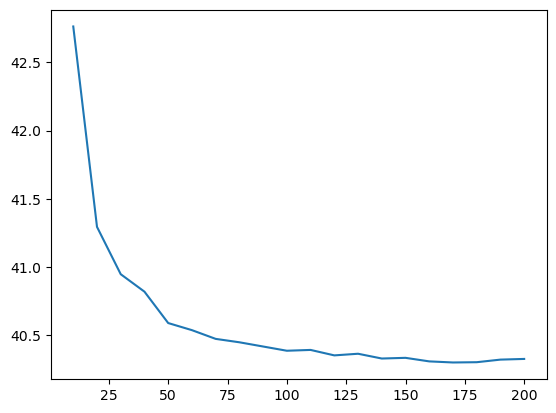

In [15]:
plt.plot(scores.n_estimators, scores.rmse.round(3))
plt.show()

In [16]:
scores

,n_estimators,rmse
0,10.0,42.763329
1,20.0,41.293539
2,30.0,40.947056
3,40.0,40.818920
4,50.0,40.588979
5,60.0,40.537018
6,70.0,40.472806
7,80.0,40.448037
8,90.0,40.417202
9,100.0,40.386316


# Question 4

In [17]:
scores = []

for d in [10, 15, 20, 25]:
    rf = RandomForestRegressor(max_depth=d,
                               random_state=1, n_jobs=-1)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

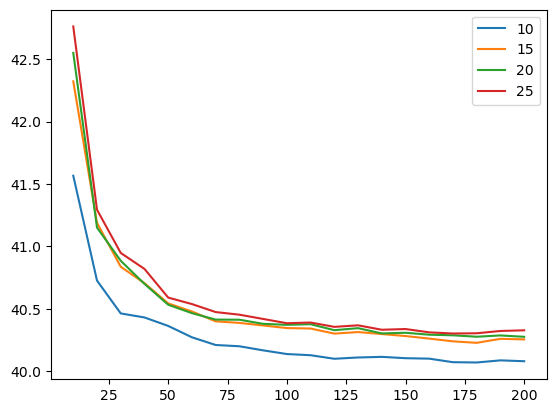

In [18]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

# Question 5

In [29]:
df_features_importance = pd.DataFrame(columns=['feature','importance'])

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

In [23]:
rf.fit(X_train,y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
df_features_importance.feature = dv.get_feature_names_out()
df_features_importance.importance = rf.feature_importances_

In [34]:
display(df_features_importance.sort_values(by='importance',ascending=False))

,feature,importance
27,study_hours_per_week,0.249198
4,attendance_rate,0.145733
5,distance_to_school,0.138679
28,teacher_quality,0.077739
2,age,0.064628
3,assignments_completed,0.027327
17,parent_involvement=High,0.026013
24,socioeconomic_status=High,0.022769
10,it_knowledge=High,0.020353
15,parent_education_level=Secondary,0.016585


# Question 6

In [56]:
scores = {}

In [57]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [59]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [60]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [61]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [62]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [63]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [64]:
scores.items()

dict_items([('eta=0.3',     num_iter  train_auc   val_auc
0          0   42.58483  44.55981
1          5   33.86153  40.53983
2         10   30.68127  40.33959
3         15   28.64574  40.75438
4         20   26.68412  41.00086
5         25   24.64161  41.52007
6         30   23.09462  41.86316
7         35   21.79365  42.09757
8         40   20.81623  42.29875
9         45   19.63310  42.47264
10        50   18.62015  42.79364
11        55   17.45512  42.92725
12        60   16.15397  43.27736
13        65   15.26968  43.30953
14        70   14.35754  43.37255
15        75   13.64163  43.54721
16        80   12.86041  43.74350
17        85   12.15777  43.79881
18        90   11.46298  43.90384
19        95   11.07237  43.93160
20       100   10.19298  44.04128
21       105    9.37515  44.14599
22       110    9.16314  44.19125
23       115    8.65470  44.26383
24       120    8.08255  44.36894
25       125    7.83447  44.40778
26       130    7.47649  44.44655
27       135    6.92422 

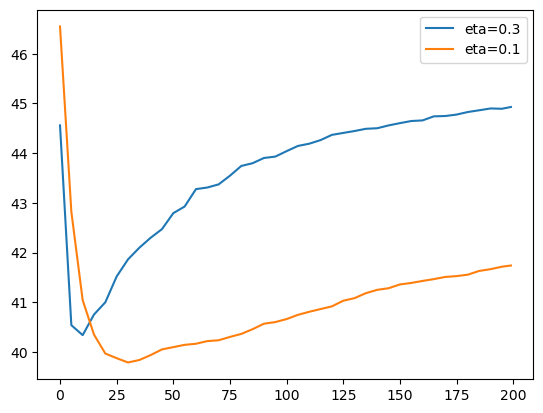

In [66]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()